<a href="https://colab.research.google.com/github/MertYuksek/canny-edge-detection-and-harris-corner-detection/blob/main/A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mert Yüksek
## Homework A2
### BIM496_Computer Vision
#### Github Link : https://github.com/MertYuksek/canny-edge-detection-and-harris-corner-detection


In [264]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import ndimage
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import math

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [265]:
# From A1; to get gradient magnitude

def get_gradient_magnitude(gx, gy):
  sum_of_squares = np.add(np.square(gx), np.square(gy))
  return np.sqrt(sum_of_squares)

In [266]:
# From A1; to get orientation 

def get_gradient_direction(gx, gy):
  return np.arctan2(gy, gx)

In [267]:
# From A1

def my_conv(img, kernel):

  img_array = np.array(img)

  # get original image size as a target
  w = img.shape[0]
  h = img.shape[1]
  k = kernel.shape[0]
  filter_img = np.zeros((w, h))

  for i in range(w):
    for j in range(h):
      mat = img_array[i:i+k, j:j+k]
      if (mat.shape == kernel.shape):
        filter_img[i][j] = np.sum(np.multiply(mat, kernel))
      else:
        filter_img[i][j] = img_array[i][j]

  return  filter_img

In [268]:
# Now, we will calculate horizontal and vertical gradient.
# Then we will find magnitude and orientation of gradient.

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = my_conv(img, Kx)
    Iy = my_conv(img, Ky)
    
    magnitude = get_gradient_magnitude(Ix, Iy).astype(np.float32)
    direction = get_gradient_direction(Ix, Iy).astype(np.float32)

    return (magnitude, direction, Ix, Iy)

In [269]:
def non_max_suppression(gradient_magnitude, gradient_direction):
 
    image_row, image_col = gradient_magnitude.shape
 
    output = np.zeros(gradient_magnitude.shape)
 
    PI = 180

    for row in range(1, image_row - 1):
      for col in range(1, image_col - 1):
          direction = gradient_direction[row, col]

          # We will find direction of the pixels
          # There are 4 regions below

          if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
              before_pixel = gradient_magnitude[row, col - 1]
              after_pixel = gradient_magnitude[row, col + 1]

          elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
              before_pixel = gradient_magnitude[row + 1, col - 1]
              after_pixel = gradient_magnitude[row - 1, col + 1]

          elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
              before_pixel = gradient_magnitude[row - 1, col]
              after_pixel = gradient_magnitude[row + 1, col]

          else:
              before_pixel = gradient_magnitude[row - 1, col - 1]
              after_pixel = gradient_magnitude[row + 1, col + 1]

          if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
              output[row, col] = gradient_magnitude[row, col]
          
    return output

In [270]:
def threshold(img, lowThreshold=10, highThreshold=90):
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(125)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return res

In [271]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    output = img.copy()
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (output[i,j] == weak):
                try:
                    if ((output[i+1, j-1] == strong) or (output[i+1, j] == strong) or (output[i+1, j+1] == strong)
                        or (output[i, j-1] == strong) or (output[i, j+1] == strong)
                        or (output[i-1, j-1] == strong) or (output[i-1, j] == strong) or (output[i-1, j+1] == strong)):
                        output[i, j] = strong
                    else:
                        output[i, j] = 0
                except IndexError as e:
                    pass
    return output

In [272]:
def result(img_smooth_gray):
  
  mag, orion, Ix, Iy = sobel_filters(img_smooth_gray)
  non_max = non_max_suppression(mag, orion)
  treshol_output = threshold(non_max)
  final_output = hysteresis(treshol_output, weak=125)

  plt.figure(figsize=(30, 30))
  plt.subplot(141), plt.imshow(mag, cmap='gray')
  plt.title("Magnitude of gradients"), plt.xticks([]), plt.yticks([])
  plt.subplot(142), plt.imshow(non_max, cmap='gray')
  plt.title("Non-Max Suppresion"), plt.xticks([]), plt.yticks([])
  plt.subplot(143), plt.imshow(treshol_output, cmap='gray')
  plt.title("Apply Treshold"), plt.xticks([]), plt.yticks([])
  plt.subplot(144), plt.imshow(final_output, cmap='gray')
  plt.title("Apply Hysteresis"), plt.xticks([]), plt.yticks([])
  plt.show()

In [273]:
def gaussian_kernel(l=5, sig=1.6):
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

In [284]:
def scale_space(img):

  # My space contains 4 image => s+1 = 4 then k=2**(1/s) = 2**(1/3), sigma1 = 1.6, sigma2 = k*sigma1, sigma3 = k**2*sigma1, sigma4 = k**3*sigma1
  # k = sqrt(2)

  img1 = img.copy()
  img2 = img.copy()
  img3 = img.copy()
  img4 = img.copy()
  img1 = my_conv(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), gaussian_kernel(3, 1.6))
  img2 = my_conv(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), gaussian_kernel(5, 1.6*(2**(1/3))))
  img3 = my_conv(cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY), gaussian_kernel(7, 1.6*((2**(1/3)**2))))
  img4 = my_conv(cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY), gaussian_kernel(9, 1.6*((2**(1/3)**3))))
  return img1, img2,img3,img4

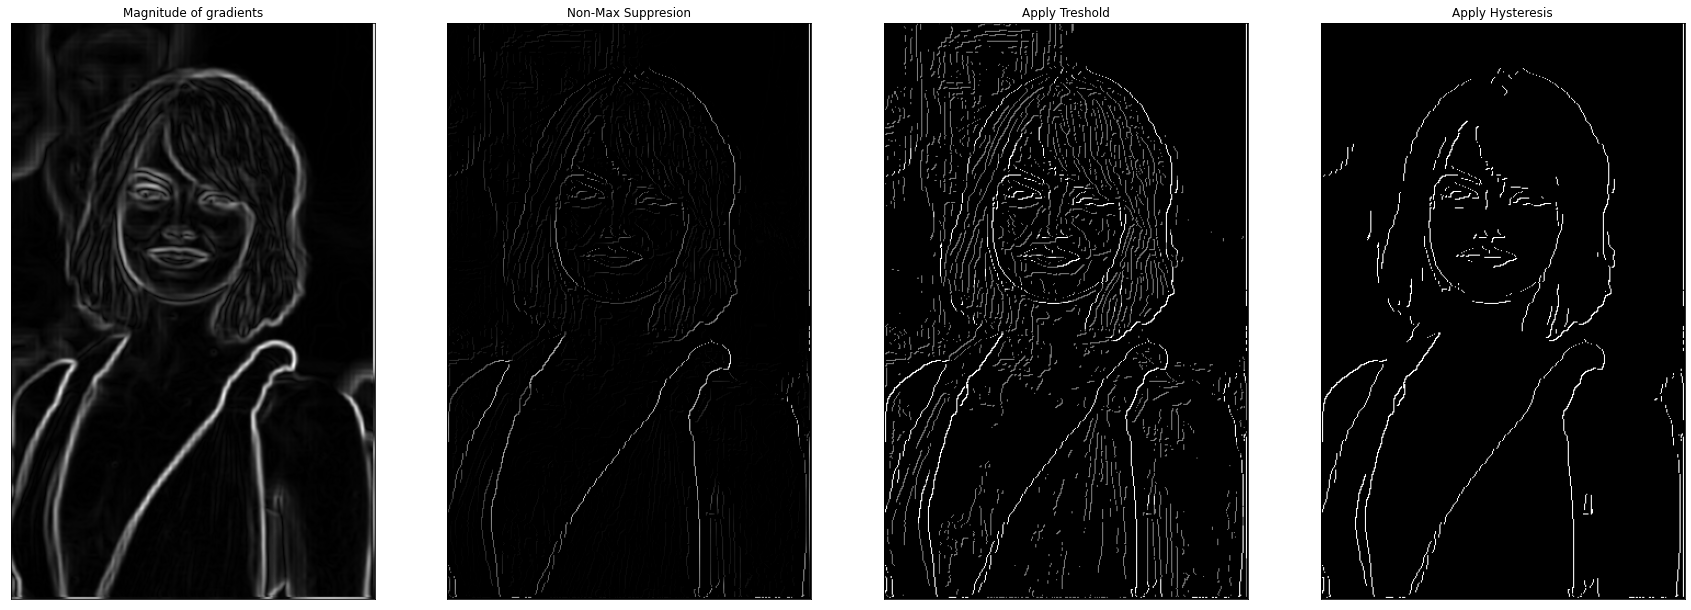

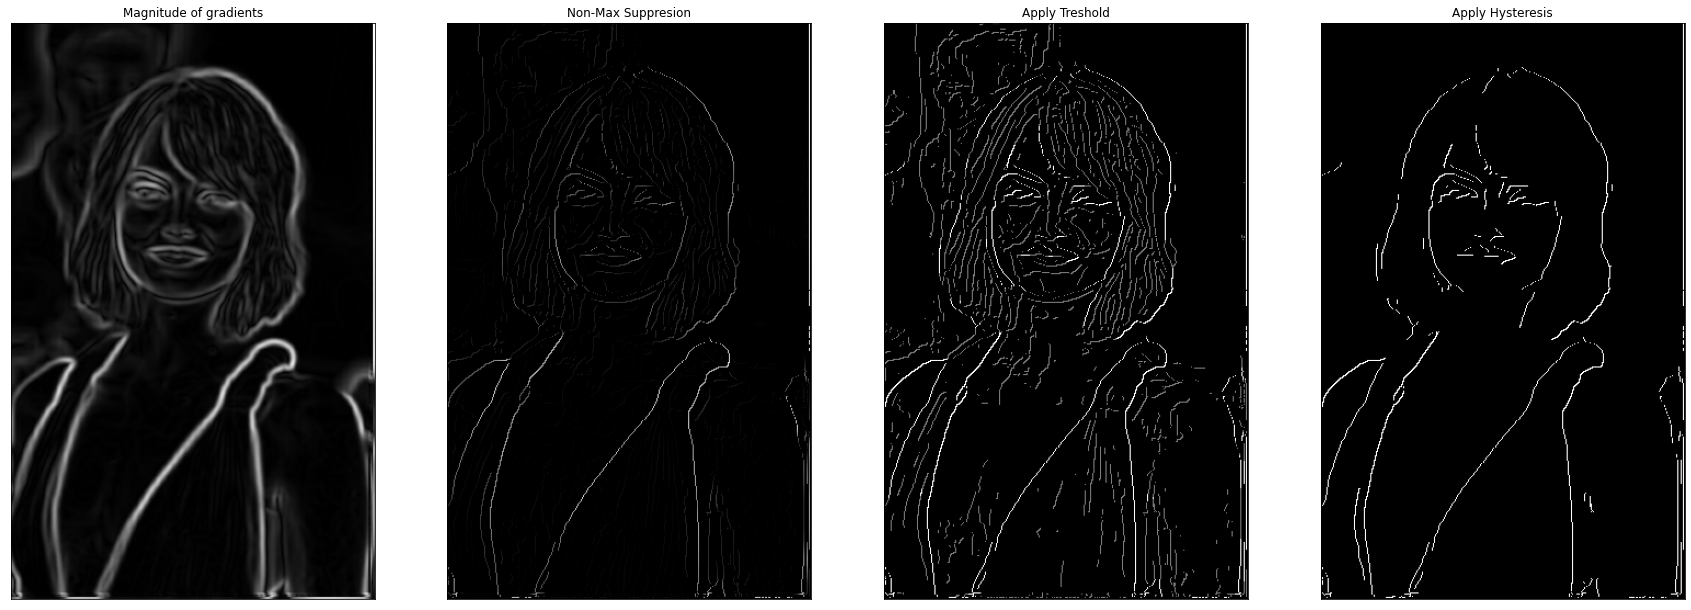

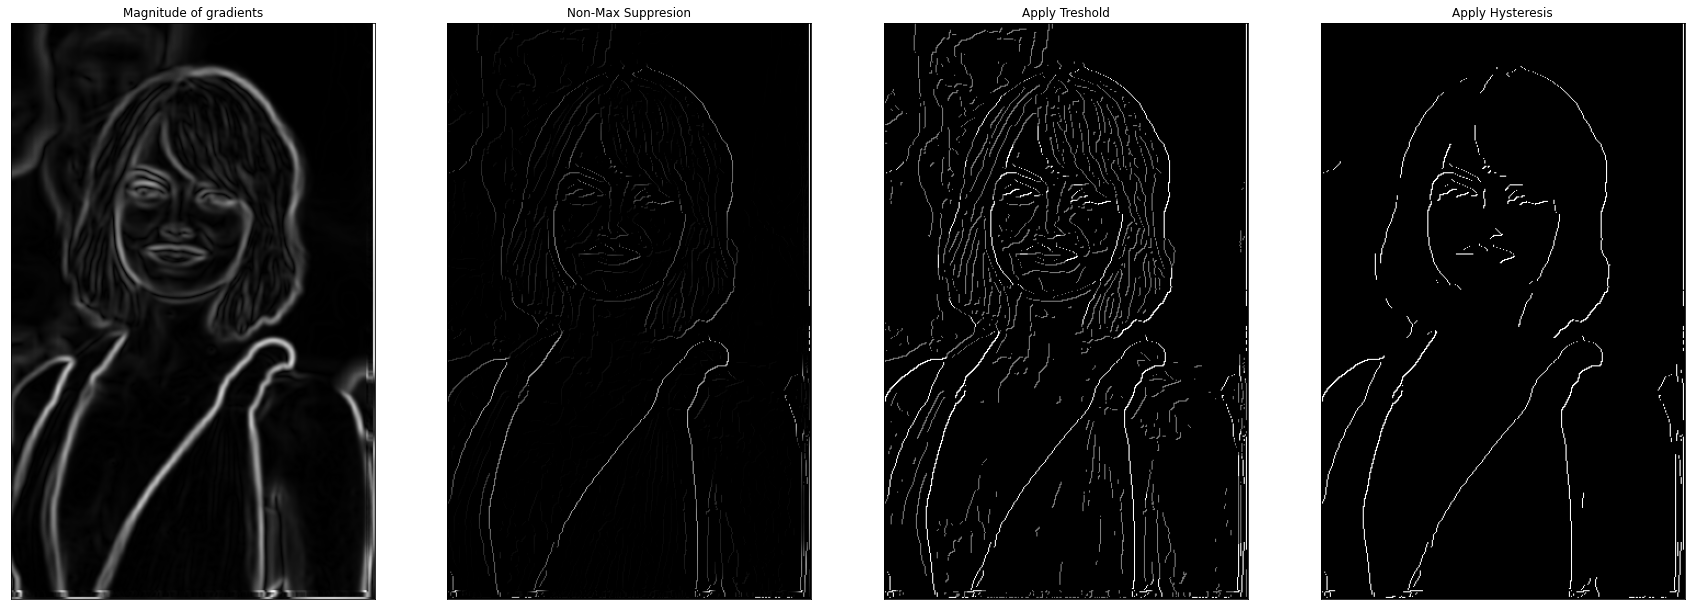

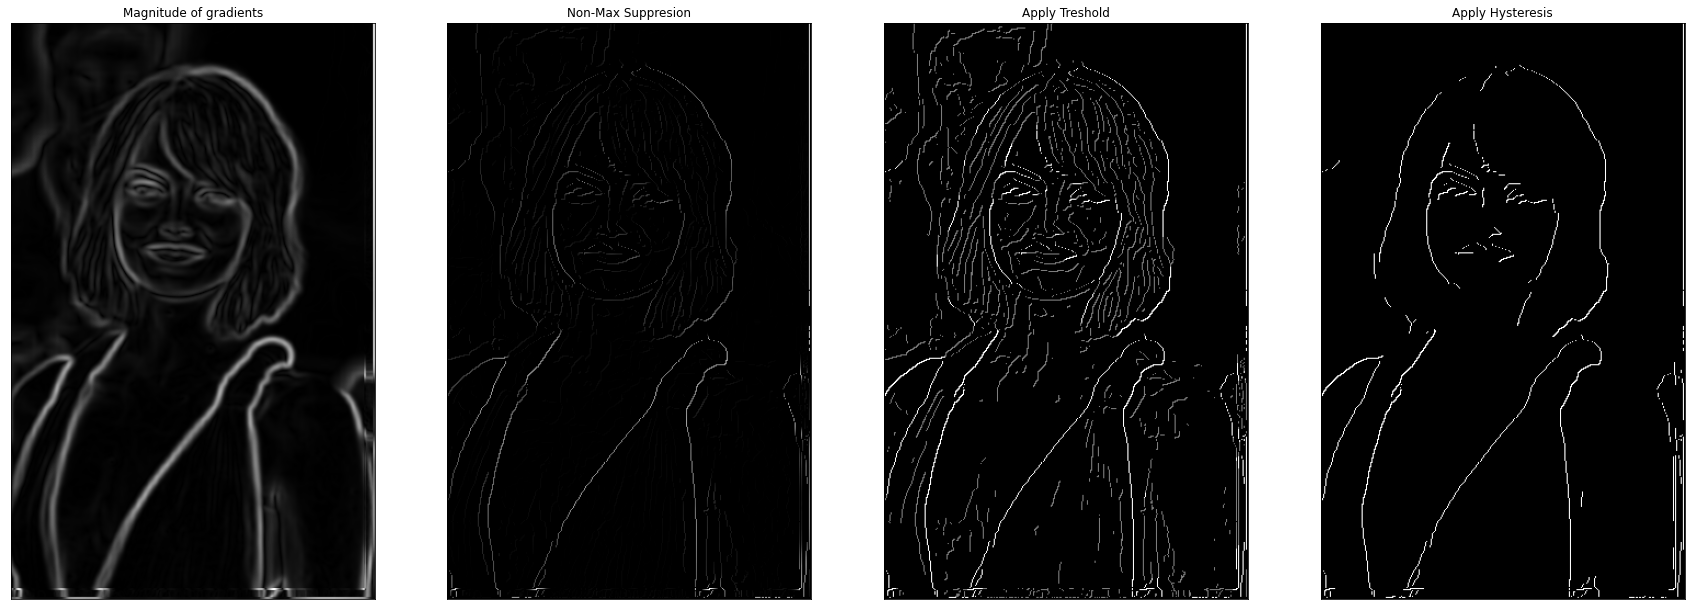

In [285]:
# Please give image path here !!!
image_path = "o.jpg"
img = cv2.imread(image_path)

for img in scale_space(img):
  result(img)

In [286]:
# Gaussian kernel
gaus_kernel = np.array((
        [1/16, 2/16, 1/16],
        [2/16, 4/16, 2/16],
        [1/16, 2/16, 1/16]), dtype="float64")

In [287]:
def harris(img, threshold=0.6):

    img_cpy = img.copy() # copying image
    img1_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grayscaling (0-1)
    
    mag, orien, dx, dy = sobel_filters(img1_gray)

    # Find Ix^2, Iy^2, Ix*Iy
    dx2 = np.square(dx)
    dy2 = np.square(dy)
    dxdy = dx*dy 

    # gauss filter for all directions (x,y,cross axis)
    g_dx2 = my_conv(dx2, gaus_kernel)
    g_dy2 = my_conv(dy2, gaus_kernel)
    g_dxdy = my_conv(dxdy, gaus_kernel)

    # Harris Function
    harris = g_dx2*g_dy2 - np.square(g_dxdy) - 0.12*np.square(g_dx2 + g_dy2) # R = det(M) – k tr(M)2

    # Normalizing inside
    cv2.normalize(harris, harris, 0, 1, cv2.NORM_MINMAX)

    # find all points above threshold (nonmax supression line)
    loc = np.where((harris > threshold))             

    for pt in zip(*loc[::-1]):
        cv2.circle(img_cpy, pt, 3, (0, 0, 255), -1)

    return img_cpy,g_dx2,g_dy2,dx,dy,loc

In [288]:
# Please give image path here !!!

img = cv2.imread('oyuncak.jpg')
corners,g_dx2,g_dy2,dx,dy,loc = harris(img,0.85)

(Text(0.5, 1.0, 'Harris Corner Output'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

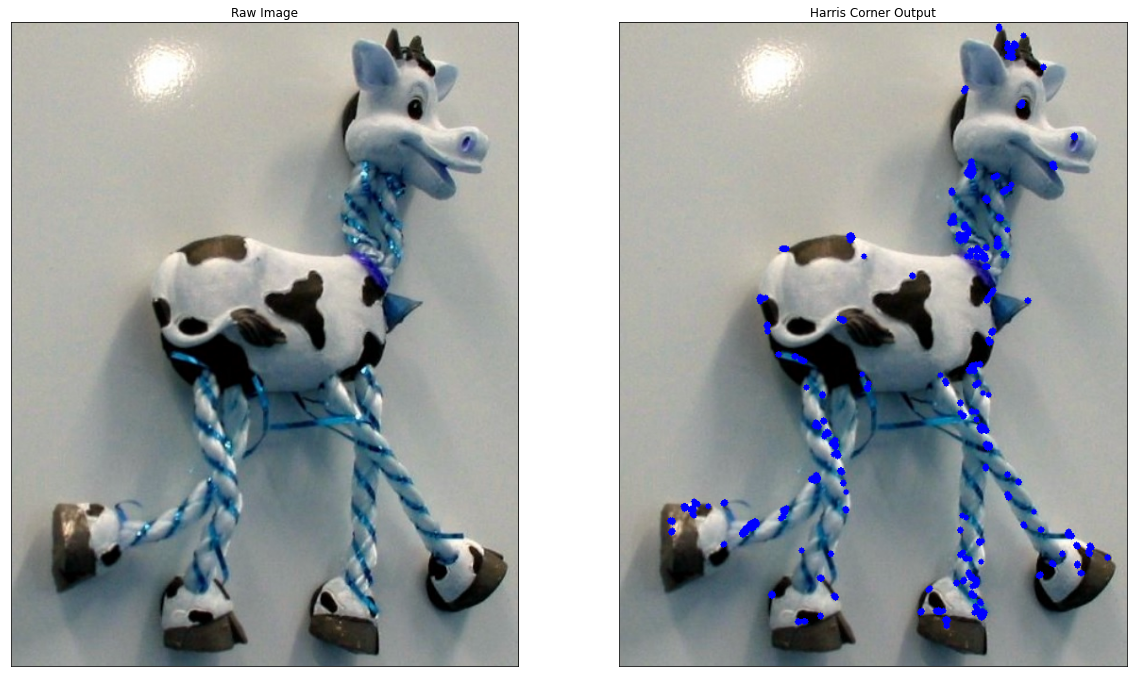

In [289]:
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img)
plt.title("Raw Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(corners)
plt.title("Harris Corner Output"), plt.xticks([]), plt.yticks([])